# Imports and Definitions

In [1907]:
import numpy as np
from queue import Queue
import scipy.integrate as sint
import matplotlib.pyplot as plt
# This part calls for the tex package with Palantino font family 
# Note latex should be installed in the system to run this
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Palatino"
})
from math import *

In [1908]:
class diff_eq_solver:
    """Class for differential equation solver.
    
    Parameters
    ----------
    domain : list of float
        The initial and final values x value to solve for f(x)
    h : float
        The initial stepsize of x to evaluate f(x)
    y0 : list of float
        The initial or boundary value depending on constraint type.
    fn : list of functions
        The function list for each differential equation.
    xb : float
        For boundary value type second order differential equations,
        x value for second boundary value in y0 list.
    stepsize : str, optional
        Stepsize type specifier, fixed or adaptive. Default is fixed.
    constraints : str, optional
        The type of problem specifier, initial or boundary.
        Default is initial.
    """
    
    def __init__(self, domain, h, y0, fn, *args, xb = None, stepsize = "fixed", constraints = "initial"):
        
        self.domain = domain
        self.x_initial = domain[0]
        self.x_final = domain[1]
        self.h = h
        self.y0 = y0
        self.fn = fn
        self.args = args
        self.stepsize = stepsize
        self.constraints = constraints
        self.xb = xb
        self.candidate_y = Queue(maxsize = 5)
        
        # Fixed step size used predefined numpy arrays initializations
        if stepsize == "fixed":
            self.n = int((self.x_final-self.x_initial)/h)
            self.x = np.linspace(self.x_initial,self.x_final,self.n)
            self.y = np.zeros((len(self.y0),self.n))
        
        # Adaptive step size used empty list initialization
        elif stepsize == "adaptive":
            self.x = []
            self.y = []
            
        else:
            raise ValueError("stepsize takes values 'fixed'/'adaptive'.")
            
        if constraints == "boundary" and len(self.fn)!=2:
            raise ValueError("Boundary value is implemented for only two variable/second order differential equations.")
        
        if constraints == "boundary" and xb == None:
            raise ValueError("Value for xb missing.")
        
        if (constraints != "initial" and constraints != "boundary"):
            raise ValueError("constraints takes values 'initial'/'boundary'.")
        

    def Runge_Kutta_4(self, delta=1e-3):
        """Method to execute a 4th Order Runge Kutta run. Supports 
        both initial and boundary value constraint type and both fixed
        and adaptive step sizes.
        """
        
        # Defines the sequence of operation for RK4
        def RK_sequence(func, xi, yi, h):
            ylist = list(yi)
            k1 = h * func(xi,*ylist,*self.args)
            ylist = list(np.array(yi)+k1*0.5)
            k2 = h * func(xi+h*0.5,*ylist,*self.args)
            ylist = list(np.array(yi)+k2*0.5)
            k3 = h * func(xi+h*0.5,*ylist,*self.args)
            ylist = list(np.array(yi)+k3)
            k4 = h * func(xi+h,*ylist,*self.args)
            return (1/6)*(k1+2*k2+2*k3+k4)
        
        if self.constraints == "initial":
            
            if self.stepsize == "fixed":
                self.y = np.full((len(self.y0),self.n),1e-6)
                for i in range(0,len(self.y0)):
                    self.y[i,0]=self.y0[i]
                for i in range(0,self.n-1):
                    j=0
                    for func in self.fn:
                        self.y[j,i+1]=self.y[j,i]+RK_sequence(func,self.x[i],self.y[:,i],self.h)
                        j=j+1

            if self.stepsize == "adaptive":
                self.y.append(np.array(self.y0))
                self.x.append(self.x_initial)
                while(self.x[-1]<=self.x_final):
                    y_cache = np.zeros(len(self.fn))
                    y_cache2 = np.zeros(len(self.fn))
                    y_cache3 = np.zeros(len(self.fn))
                    er = []
                    
                    j=0
                    for func in self.fn:
                        y_cache[j] = self.y[-1][j]+RK_sequence(func,self.x[-1],self.y[-1][:],self.h)
                        j = j + 1
                    self.x.append(self.x[-1]+self.h)
                    self.y.append(y_cache)
                    j=0
                    for func in self.fn:
                        y_cache2[j] = self.y[-1][j] + RK_sequence(func,self.x[-1],self.y[-1][:],self.h)
                        y_cache3[j] = self.y[-2][j] + RK_sequence(func,self.x[-2],self.y[-2][:],2*self.h)
                        er.append(abs(y_cache2[j] - y_cache3[j])/30)
                        j = j + 1
                    er_norm = np.linalg.norm(er)
                    if er_norm != 0:
                        self.h = self.h*(delta*self.h/er_norm)**(1/4)
                    
                self.n = len(self.x)
                self.x = np.array(self.x)
                self.y = np.array(self.y).T
                
        if self.constraints == "boundary":
            self.a = self.Newton_Raphson(self.__shooting_function, "Runge_Kutta_4")

    def Euler_Method(self):
        """Method to execute a Euler Method run. Supports initial and
        boundary value constraints. Currently does not support adaptive
        step size.
        """
        
        if self.stepsize == "adaptive":
            raise TypeError("Adaptive stepsizes are currently not supported with Euler Method.")
            
        if self.constraints == "initial":
            self.y = np.full((len(self.y0),self.n),1e-6)
            for i in range(0,len(self.y0)):
                self.y[i,0]=self.y0[i]
            for i in range(0,self.n-1):
                j=0
                for func in self.fn:
                    ylist=list(self.y[:,i])
                    f=self.h*func(self.x[i],*ylist,*self.args)
                    self.y[j,i+1]=self.y[j,i]+f
                    j=j+1
         
        # If constraint is boundary, use shooting with Newton Raphson
        if self.constraints == "boundary":
            self.a = self.Newton_Raphson(self.__shooting_function, "Euler_Method")
                
    def Backward_Euler_Method(self):
        """Method to execute a Backward Euler Method run."""
        
        if len(self.fn) != 1:
            raise ValueError("Backward Euler Method is implemented only for 1 variable differential equations.")
        
        def back_g(om, func, x, om_j):
            ylist = list()
            return self.h * func(x, om, *self.args) + om_j - om
        
        self.y = np.full((len(self.y0),self.n),1e-6)
        for i in range(0,len(self.y0)):
            self.y[i,0]=self.y0[i]
        for i in range(0,self.n-1):
            j=0
            for func in self.fn:
                ylist=list(self.y[:,i])
                self.y[j,i+1]=self.Newton_Raphson(back_g, func, self.x[i+1], *ylist)
                j=j+1
    
    def Relaxation_Method(self, tol = 1e-2):
        
        if len(self.fn) != 2:
            raise ValueError("Relaxation Method is implemented only for second order differential equations.")
        
        if self.constraints != "boundary":
            raise TypeError("Relaxation Method only works for boundary value conditions.")
            
        if self.stepsize != "fixed":
            raise TypeError("Relaxation Method only works for fixed stepsize.")
            
        if self.x_final != xb:
            raise ValueError("Relaxation Methods only works within the domain of the two boundaries.")
        
        self.y = np.zeros((len(self.y0),self.n))
        self.y[0,0] = self.y0[0]
        self.y[0,-1] = self.y0[1]
        er = tol + 1
        itr = 0
        self.candidate_y = Queue(maxsize = 5)
        while (er > tol):
            itr += 1
            prob = itr*tol**2*self.h
            y_cache = np.copy(self.y)
            for i in range(1,self.n-1):
                ylist = list(self.y[:,i])
                self.y[0,i] = (self.y[0,i-1]+self.y[0,i+1]-((self.h)**2)*self.fn[1](self.x[i], *ylist, *self.args))/2
            er = np.linalg.norm(self.y[0,:]-y_cache[0,:])
            
            if np.random.choice([0, 1], size=(1,), p=[1-prob, prob])[0] == 1 and self.candidate_y.full() == False:
                self.candidate_y.put_nowait(np.copy(self.y))
                print("Candidate solution taken from interation ",itr)
        print("Total no. of Iterations = ", itr)
        
    def Newton_Raphson(self, eqn, *args, tol=1e-3):
        x = 0.1
        x_n = x+1
        while (np.abs(x_n - x) > tol):
            x_n = x
            x = x_n-2*tol*eqn(x_n, *args)/(eqn(x_n+tol, *args)-eqn(x_n-tol, *args))
        return x
    
    def __shooting_function(self, trial, method):
        y0 = [self.y0[0],trial]
        diff_eq = diff_eq_solver(self.domain, self.h, y0, self.fn, *self.args, xb = self.xb, stepsize = self.stepsize, constraints = "initial")
        getattr(diff_eq,method)()
        i1 = np.argmin(np.abs(diff_eq.x - self.xb))
        if self.candidate_y.full() == True:
            self.candidate_y.get()
        self.candidate_y.put_nowait(np.copy(diff_eq.y))
        self.y = diff_eq.y
        return (diff_eq.y[0,i1] - self.y0[1])
        
    def error(self, true_func, error_type="relative", order = None):
        true_y = np.vectorize(true_func)(self.x,*self.args)
        if error_type == "absolute":
            er = np.linalg.norm(true_y-self.y[0,:],ord=order)
        if error_type == "relative":
            er = np.linalg.norm((true_y-self.y[0,:]),ord=order)/np.linalg.norm(true_y,ord=order)
        return er
    
    # For quick plotting the numerical solution
    @property
    def qplot(self):
        plt.plot(self.x,self.y.T)
        
    def plot(
        self, 
        plot_index = None,
        plot_label = None,
        title = r'Plot for $f(x)$ vs. $x$', 
        xlabel = r'$x$', 
        ylabel = r'$f(x)$',
        style = '-',
        linewidth = 1,
        markersize = None,
        zorder = 10
    ):
        f, ax = plt.subplots(figsize=(10,5))
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.grid()
        plt.margins(x=0)
        if plot_index==None:
            ax.plot(self.x,self.y.T, style, linewidth = linewidth, markersize = markersize, label=plot_label, zorder = zorder)
        elif isinstance(plot_index,int)==True:
            ax.plot(self.x,self.y[plot_index,:], style, linewidth = linewidth, markersize = markersize, label="Numerical Solution", zorder = zorder)
        return f, ax

## A couple of Tests

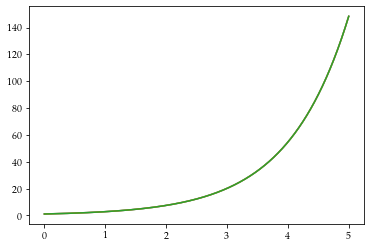

In [1909]:
def testy(x,y):
    return y

def true_y(x):
    return np.exp(x)

y0=[1]
fn=[testy]
diff_eq_test1 = diff_eq_solver([0,5],2.02148251886947e-05,y0,fn)
diff_eq_test1.Runge_Kutta_4()
er1 = diff_eq_test1.error(true_y)
diff_eq_test1.qplot
diff_eq_test1.Euler_Method()
er2 = diff_eq_test1.error(true_y)
diff_eq_test1.qplot
diff_eq_test1.Backward_Euler_Method()
er3 = diff_eq_test1.error(true_y)
diff_eq_test1.qplot

In [1910]:
print(diff_eq_test1.n)
print(er1,er2,er3)

247343
2.2374497648092873e-05 6.813592371152102e-05 2.339028720633605e-05


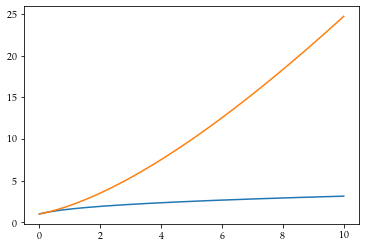

In [1911]:
# An example for two variable systems of differential equations
def testy1(x,y,z):
    return 1/y**2
def testy2(x,y,z):
    return np.log(z+y)
y0=[1,1]
fn=[testy1,testy2]
diff_eq_test2 = diff_eq_solver([0,10],0.01,y0,fn)
diff_eq_test2.Runge_Kutta_4()
diff_eq_test2.qplot

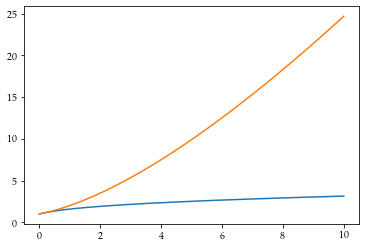

In [1912]:
diff_eq_test2.Euler_Method()
diff_eq_test2.qplot

In [1913]:
# Backward Euler Method is currently implemented only for one variable differential equations. Pushing two or more variables will lead to a value error.
# To see the type error message uncomment the next two lines and run the block.
# diff_eq_test2.Backward_Euler_Method()
# diff_eq_test2.plot

31


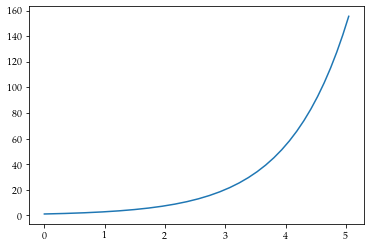

In [1914]:
def testy(x,y):
    return y
y0=[1]
fn=[testy]
diff_eq_test3 = diff_eq_solver([0,5],0.01,y0,fn,stepsize="adaptive")
diff_eq_test3.Runge_Kutta_4(delta=0.0001)
print(diff_eq_test3.n)
diff_eq_test3.qplot

In [1915]:
print(diff_eq_test3.h)
print(diff_eq_test3.error(true_y))

0.09537797727095494
0.00010336846384773015


# Problem 1

In [1916]:
# Function definitions and initializations
def f1(x,y):
    return -9*y

def f2(x,y):
    return -20*(y-x)**2+2*x

domain = [0, 1]
h = 0.001
y01 = [np.exp(1)]
y02 = [1/3]

In [1917]:
# Defining the two differential equation classes
diff_eq_q11 = diff_eq_solver(domain,h,y01,[f1])
diff_eq_q12 = diff_eq_solver(domain,h,y02,[f2])

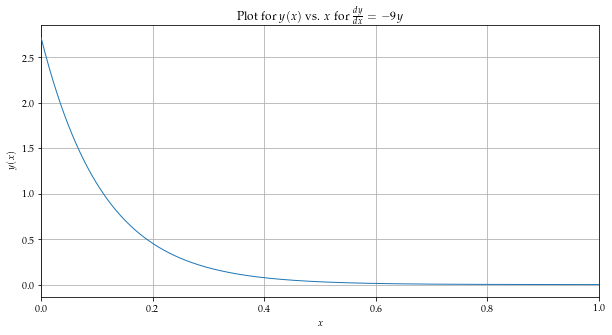

In [1918]:
# Solving first differential equation using Backward Euler Method
diff_eq_q11.Backward_Euler_Method()
# Plotting the result
f1, ax1 = diff_eq_q11.plot(
    plot_index = 0,
    title = r'Plot for $y(x)$ vs. $x$ for $\frac{dy}{dx}=-9y$', 
    xlabel = r'$x$', 
    ylabel = r'$y(x)$')

f1.savefig('q1plot1.pdf',bbox_inches='tight')

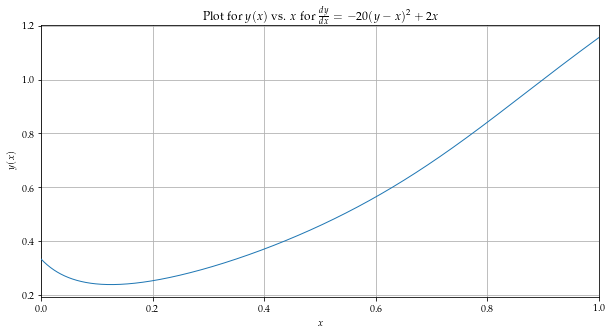

In [1919]:
# Solving second differential equation using Backward Euler Method
diff_eq_q12.Backward_Euler_Method()
# Plotting the result
f2, ax2 = diff_eq_q12.plot(
    plot_index = 0,
    title = r'Plot for $y(x)$ vs. $x$ for $\frac{dy}{dx}=-20(y-x)^2+2x$', 
    xlabel = r'$x$', 
    ylabel = r'$y(x)$')

f2.savefig('q1plot2.pdf',bbox_inches='tight')

# Problem 2

In [1920]:
# Function definitions and initializations
def f(t,y):
    return y/t-(y/t)**2

def y_true(t):
    return t/(1+np.log(t))
    
domain = [1, 2]
h = 0.1
y0 = [1]
fn = [f]

In [1921]:
# Defining the differential equation class for this problem
diff_eq_q2 = diff_eq_solver(domain,h,y0,fn)

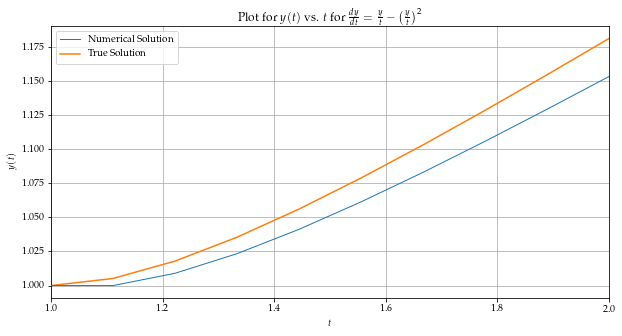

In [1922]:
# Solving the differential equation using Euler Method
diff_eq_q2.Euler_Method()
# Plotting the result
f3, ax3 = diff_eq_q2.plot(
    plot_index = 0,
    title = r'Plot for $y(t)$ vs. $t$ for $\frac{dy}{dt}=\frac{y}{t}-\left(\frac{y}{t}\right)^2$', 
    xlabel = r'$t$', 
    ylabel = r'$y(t)$')

# Plotting the true solution
ax3.plot(diff_eq_q2.x,np.vectorize(y_true)(diff_eq_q2.x), label='True Solution')
ax3.legend()
f3.savefig('q2plot.pdf',bbox_inches='tight')

In [1923]:
# Relative and absolute error calculated using L2 norm
absolute_error = diff_eq_q2.error(y_true,error_type="absolute")
relative_error = diff_eq_q2.error(y_true,error_type="relative")

print("Absolute error = ",absolute_error)
print("Relative error = ",relative_error)

Absolute error =  0.055810553328758776
Relative error =  0.016374608757314103


# Problem 3

In [1924]:
# Function definitions and initializations
def dydx(x,y,v):
    return v

def dvdx(x,y,v):
    return 2*v-y+x*np.exp(x)-x

def y_true(x):
    return (-12+12*np.exp(x)-6*x-6*np.exp(x)*x
+np.exp(x)*x**3)/6
    
domain = [0, 1]
h = 0.01
y0 = [0,0]
fn = [dydx,dvdx]

In [1925]:
# Defining the differential equation class for this problem
diff_eq_q3 = diff_eq_solver(domain,h,y0,fn)

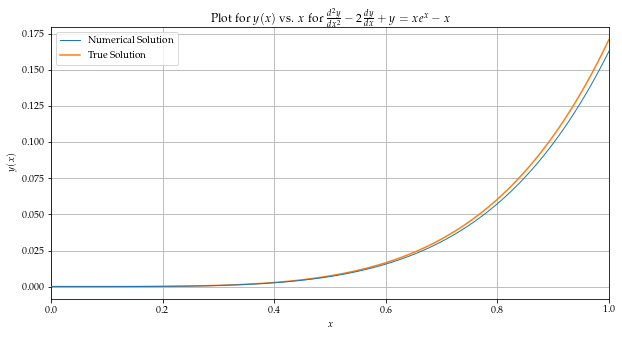

In [1926]:
# Solving the differential equation using Euler Method
diff_eq_q3.Runge_Kutta_4()
# Plotting the result for y(x)
f4, ax4 = diff_eq_q3.plot(
    plot_index = 0,
    title = r'Plot for $y(x)$ vs. $x$ for $\frac{d^2y}{dx^2}-2\frac{dy}{dx}+y=xe^x-x$', 
    xlabel = r'$x$', 
    ylabel = r'$y(x)$')

# Plotting the true solution
ax4.plot(diff_eq_q3.x,np.vectorize(y_true)(diff_eq_q3.x), label='True Solution')
ax4.legend()
f4.savefig('q3plot.pdf',bbox_inches='tight')

In [1927]:
# Relative and absolute error calculated using L2 norm
absolute_error = diff_eq_q3.error(y_true,error_type="absolute")
relative_error = diff_eq_q3.error(y_true,error_type="relative")

print("Absolute error = ",absolute_error)
print("Relative error = ",relative_error)

Absolute error =  0.02669435458623042
Relative error =  0.04907666647609621


# Problem 6

In [1928]:
# Defining the functions and the boundary conditions.
def dxdt(t,x,v):
    return v

def dvdt(t,x,v):
    return -10

fn = [dxdt, dvdt]
y0 = [0, 0]
xb = 10
h= 0.05
domain = [0,10]

In [1929]:
# First we will define the class for the boundary value problem
diff_eq_x = diff_eq_solver(domain, h, y0, fn, xb = xb, constraints = "boundary")
# Then we will use the Euler Method to solve the differential equation
diff_eq_x.Euler_Method()
# Then we fetch a for x'(t_0) = a; here t_0 = 10
print("a =",diff_eq_x.a)
# We can pick candidate solution from the candidate solution queue or construct manually.
# We will do it manually for this problem and using queue in the next problem.
print("Candidate solution queue size = ",diff_eq_x.candidate_y.qsize())

a = 49.499999999999986
Candidate solution queue size =  5


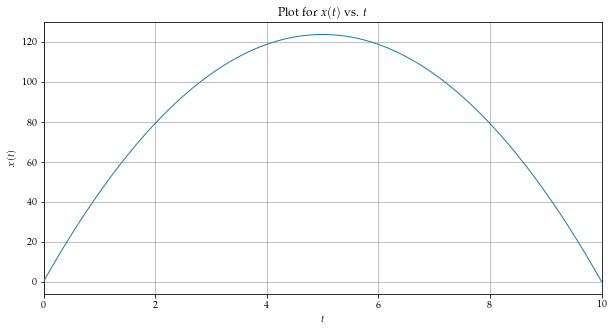

In [1930]:
# Plot for the numerical solution using Euler Method with Shooting
f, ax = diff_eq_x.plot(
    plot_index = 0,
    title = r'Plot for $x(t)$ vs. $t$', 
    xlabel = r'$t$', 
    ylabel = r'$x(t)$')

In [1931]:
def true_x(t):
    return -5*(-10*t+t**2)

# We will calculate solutions for values of a close to the fetched value
candidate_sol1 = diff_eq_solver(domain, h,[0,30], fn, xb = xb, constraints = "initial")
candidate_sol1.Euler_Method()
candidate_sol2 = diff_eq_solver(domain, h, [0,35], fn, xb = xb, constraints = "initial")
candidate_sol2.Euler_Method()
candidate_sol3 = diff_eq_solver(domain, h, [0,40], fn, xb = xb, constraints = "initial")
candidate_sol3.Euler_Method()
candidate_sol4 = diff_eq_solver(domain, h, [0,44], fn, xb = xb, constraints = "initial")
candidate_sol4.Euler_Method()
candidate_sol5 = diff_eq_solver(domain, h, [0,47], fn, xb = xb, constraints = "initial")
candidate_sol5.Euler_Method()

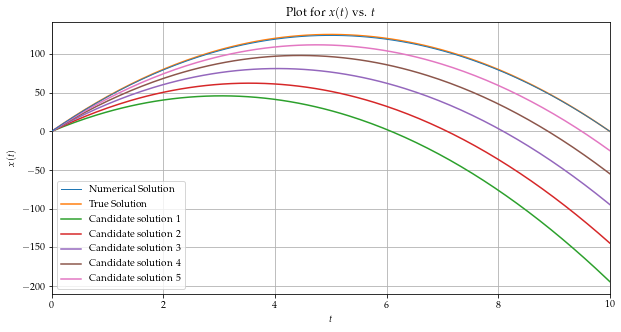

In [1932]:
# This figure contains numerical solution, true solution and 5 candidate solutions
# Note: Do not run this block twice in isolation as it will keep adding plots.
ax.plot(diff_eq_x.x,np.vectorize(true_x)(diff_eq_x.x), label='True Solution')
ax.plot(diff_eq_x.x,candidate_sol1.y[0,:], label='Candidate solution 1')
ax.plot(diff_eq_x.x,candidate_sol2.y[0,:], label='Candidate solution 2')
ax.plot(diff_eq_x.x,candidate_sol3.y[0,:], label='Candidate solution 3')
ax.plot(diff_eq_x.x,candidate_sol4.y[0,:], label='Candidate solution 4')
ax.plot(diff_eq_x.x,candidate_sol5.y[0,:], label='Candidate solution 5')
ax.legend()

f.savefig('q6plot.pdf',bbox_inches='tight')
f.figure

In [1933]:
# The absolute error for the numerical solution is given below
diff_eq_x.error(true_x, error_type = "absolute")

12.909597067183523

# Problem 7

In [1934]:
# Since this differential equation object for this problem was already defined we will directly apply Relaxation Method
diff_eq_x.Relaxation_Method(tol = 1e-3)

Candidate solution taken from interation  7575
Candidate solution taken from interation  9331
Candidate solution taken from interation  9506
Candidate solution taken from interation  12491
Candidate solution taken from interation  14072
Total no. of Iterations =  23114


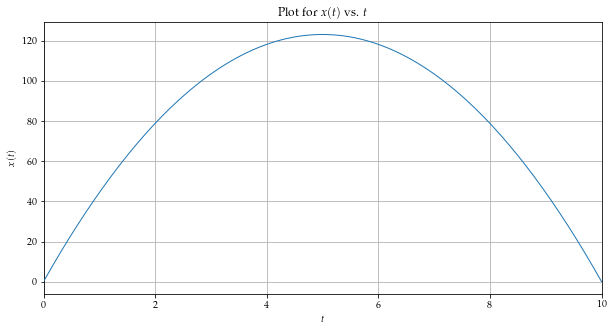

In [1935]:
# Plot for the numerical solution using Relaxation Method
f, ax = diff_eq_x.plot(
    plot_index = 0,
    title = r'Plot for $x(t)$ vs. $t$', 
    xlabel = r'$t$', 
    ylabel = r'$x(t)$')

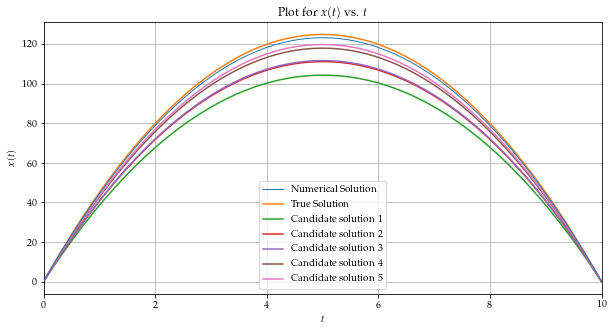

In [1936]:
# This figure contains numerical solution, true solution and 5 candidate solutions
# Note: Do not run this block twice in isolation. Running it once has already emptied the candidate solution queue.
ax.plot(diff_eq_x.x,np.vectorize(true_x)(diff_eq_x.x), label='True Solution')
ax.plot(diff_eq_x.x,diff_eq_x.candidate_y.get_nowait()[0,:], label='Candidate solution 1')
ax.plot(diff_eq_x.x,diff_eq_x.candidate_y.get_nowait()[0,:], label='Candidate solution 2')
ax.plot(diff_eq_x.x,diff_eq_x.candidate_y.get_nowait()[0,:], label='Candidate solution 3')
ax.plot(diff_eq_x.x,diff_eq_x.candidate_y.get_nowait()[0,:], label='Candidate solution 4')
ax.plot(diff_eq_x.x,diff_eq_x.candidate_y.get_nowait()[0,:], label='Candidate solution 5')
ax.legend()

f.savefig('q7plot.pdf',bbox_inches='tight')
f.figure

In [1937]:
# The absolute error for the numerical solution is given below
diff_eq_x.error(true_x, error_type = "absolute")

16.854668736042

# Problem 8

In [1938]:
# Definitions and initializations
def f81(t,y):
    return t*np.exp(3*t)-2*y

def f82(t,y):
    return 1-(t-y)**2

def f83(t,y):
    return 1+y/t

def f84(t,y):
    return np.cos(2*t)+np.sin(3*t)

domain1 = [0,1]
y01 = [0]
t1 = np.linspace(0,1,1000)

domain2 = [2,3]
y02 = [1]
t2 = np.linspace(2,2.99999,1000)

domain3 = [1,2]
y03 = [2]
t3 = np.linspace(1,2,1000)

domain4 = [0,1]
y04 = [1]
t4 = np.linspace(0,1,1000)

In [1939]:
# True solutions
def true_y81(t):
    return np.exp(-2*t)*(1-np.exp(5*t)+5*np.exp(5*t)*t)/25

def true_y82(t):
    return (1-3*t+t**2)/(t-3)

def true_y83(t):
    return 2*t+t*np.log(t)

def true_y84(t):
    return (8-2*np.cos(3*t)+3*np.sin(2*t))/6

In [1940]:
y1 = sint.solve_ivp(f81,domain1,y01,t_eval=t1)

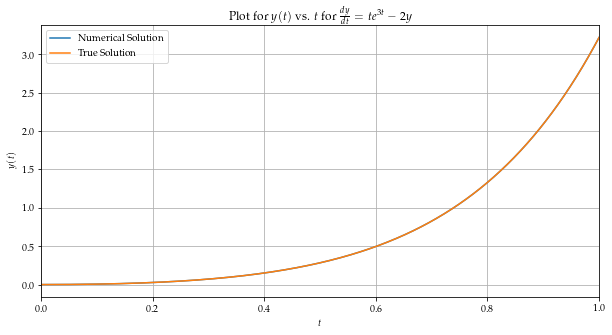

In [1941]:
f8_1 = plt.figure(figsize=(10,5))
plt.title(r'Plot for $y(t)$ vs. $t$ for $\frac{dy}{dt} = te^{3t}-2y$')
plt.xlabel(r'$t$')
plt.ylabel(r'$y(t)$')
plt.grid()
plt.margins(x=0)
plt.plot(y1.t,y1.y.T,label="Numerical Solution")
plt.plot(t1,np.vectorize(true_y81)(t1),label="True Solution")
plt.legend()

f8_1.savefig('q8plot1.pdf',bbox_inches='tight')

In [1942]:
y2 = sint.solve_ivp(f82,domain2,y02,t_eval=t2)

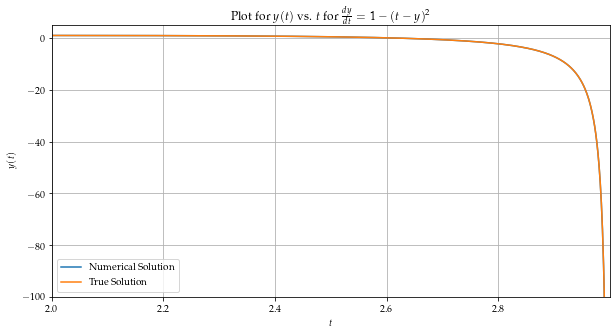

In [1943]:
f8_2 = plt.figure(figsize=(10,5))
plt.title(r'Plot for $y(t)$ vs. $t$ for $\frac{dy}{dt} = 1-(t-y)^2$')
plt.xlabel(r'$t$')
plt.ylabel(r'$y(t)$')
plt.grid()
plt.margins(x=0)
plt.plot(y2.t,y2.y.T,label="Numerical Solution")
plt.plot(t2,np.vectorize(true_y82)(t2),label="True Solution")
plt.ylim([-100,5])
plt.legend()

f8_2.savefig('q8plot2.pdf',bbox_inches='tight')

In [1944]:
y3 = sint.solve_ivp(f83,domain3,y03,t_eval=t3)

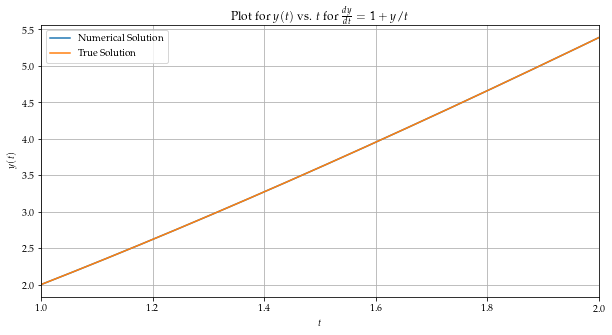

In [1945]:
f8_3 = plt.figure(figsize=(10,5))
plt.title(r'Plot for $y(t)$ vs. $t$ for $\frac{dy}{dt} = 1+y/t$')
plt.xlabel(r'$t$')
plt.ylabel(r'$y(t)$')
plt.grid()
plt.margins(x=0)
plt.plot(y3.t,y3.y.T,label="Numerical Solution")
plt.plot(t3,np.vectorize(true_y83)(t3),label="True Solution")
plt.legend()

f8_3.savefig('q8plot3.pdf',bbox_inches='tight')

In [1946]:
y4 = sint.solve_ivp(f84,domain4,y04,t_eval=t4)

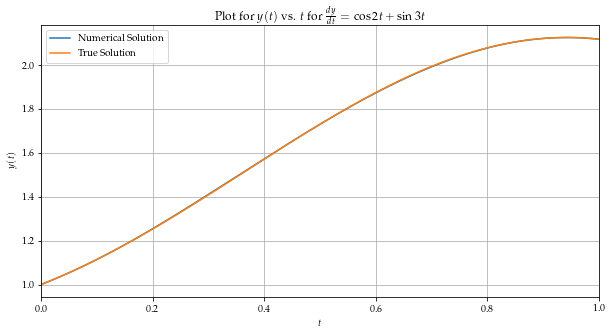

In [1947]:
f8_4 = plt.figure(figsize=(10,5))
plt.title(r'Plot for $y(t)$ vs. $t$ for $\frac{dy}{dt} = \cos 2t + \sin 3t$')
plt.xlabel(r'$t$')
plt.ylabel(r'$y(t)$')
plt.grid()
plt.margins(x=0)
plt.plot(y4.t,y4.y.T,label="Numerical Solution")
plt.plot(t4,np.vectorize(true_y84)(t4),label="True Solution")
plt.legend()

f8_4.savefig('q8plot4.pdf',bbox_inches='tight')

# Problem 9

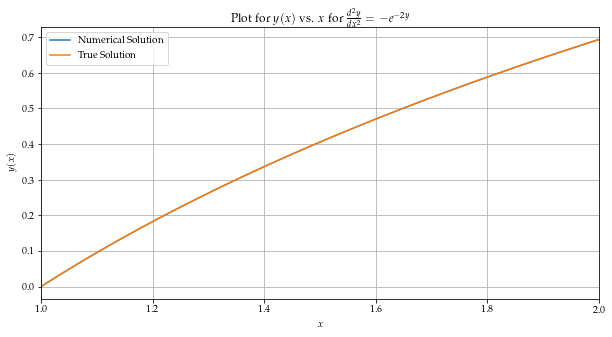

In [1948]:
def fun1(x,y):
    return np.vstack((y[1],-np.exp(-2*y[0])))

def bc1(ya, yb):
    return np.array([ya[0]-0,yb[0]-np.log(2)])

def true_y91(x):
    return np.log(x)

x1 = np.linspace(1, 2, 1000)
y1 = np.zeros((2, x1.size))

sol1 = sint.solve_bvp(fun1, bc1, x1, y1)

f9_1 = plt.figure(figsize=(10,5))
plt.title(r'Plot for $y(x)$ vs. $x$ for $\frac{d^2y}{dx^2} = -e^{-2y}$')
plt.xlabel(r'$x$')
plt.ylabel(r'$y(x)$')
plt.grid()
plt.margins(x=0)
plt.plot(x1, sol1.sol(x1)[0], label="Numerical Solution")
plt.plot(x1,np.vectorize(true_y91)(x1),label="True Solution")
plt.legend()

f9_1.savefig('q9plot1.pdf',bbox_inches='tight')

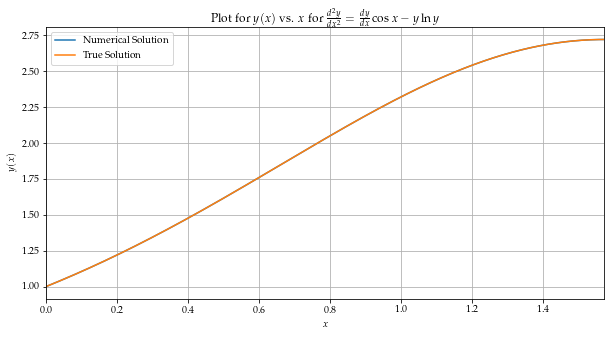

In [1949]:
def fun2(x,y):
    return np.vstack((y[1],y[1]*np.cos(x)-y[0]*np.log(y[0])))

def bc2(ya, yb):
    return np.array([ya[0]-1,yb[0]-np.exp(1)])

def true_y92(x):
    return np.exp(np.sin(x))

x2 = np.linspace(0,np.pi/2,1000)
y2 = np.ones((2, x1.size))

sol2 = sint.solve_bvp(fun2, bc2, x2, y2)

f9_2 = plt.figure(figsize=(10,5))
plt.title(r'Plot for $y(x)$ vs. $x$ for $\frac{d^2y}{dx^2} = \frac{dy}{dx}\cos x-y\ln y$')
plt.xlabel(r'$x$')
plt.ylabel(r'$y(x)$')
plt.grid()
plt.margins(x=0)
plt.plot(x2, sol2.sol(x2)[0], label="Numerical Solution")
plt.plot(x2,np.vectorize(true_y92)(x2),label="True Solution")
plt.legend()

f9_2.savefig('q9plot2.pdf',bbox_inches='tight')

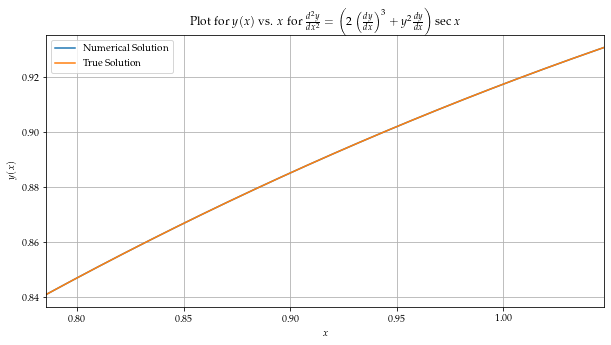

In [1950]:
def fun3(x,y):
    return np.vstack((y[1], -(2*(y[1])**3 + (y[0]**2)*y[1])*(1/np.cos(x))))

def bc3(ya, yb):
    return np.array([ya[0] - 2**(-1/4), yb[0] - (12**(1/4))/2])

def true_y93(x):
    return np.sqrt(np.sin(x))

x3 = np.linspace(np.pi/4,np.pi/3,1000)
y3 = np.full((2, x2.size),1e-6)

sol3 = sint.solve_bvp(fun3, bc3, x3, y3)

f9_3 = plt.figure(figsize=(10,5))
plt.title(r'Plot for $y(x)$ vs. $x$ for $\frac{d^2y}{dx^2} = \left(2\left(\frac{dy}{dx}\right)^3+y^2\frac{dy}{dx}\right)\sec x$')
plt.xlabel(r'$x$')
plt.ylabel(r'$y(x)$')
plt.grid()
plt.margins(x=0)
plt.plot(x3, sol3.sol(x3)[0], label="Numerical Solution")
plt.plot(x3,np.vectorize(true_y93)(x3),label="True Solution")
plt.legend()

f9_3.savefig('q9plot3.pdf',bbox_inches='tight')

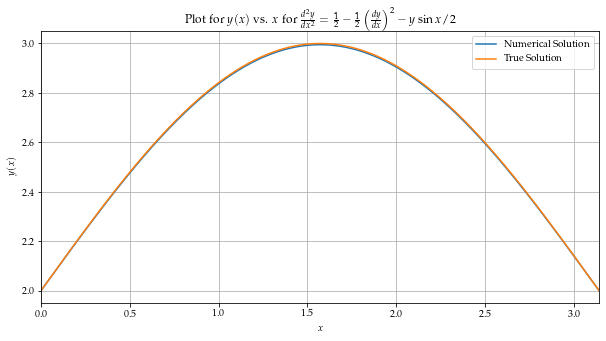

In [1951]:
def fun4(x,y):
    return np.vstack((y[1], (1 - y[1]**2 - (y[0]*np.sin(x)))/2))

def bc4(ya, yb):
    return np.array([ya[0] - 2, yb[0] - 2])

def true_y94(x):
    return 2+np.sin(x)

x4 = np.linspace(0,np.pi,1000)
y4 = np.full((2, x2.size),1e-6)

sol4 = sint.solve_bvp(fun4, bc4, x4, y4)

f9_4 = plt.figure(figsize=(10,5))
plt.title(r'Plot for $y(x)$ vs. $x$ for $\frac{d^2y}{dx^2} = \frac{1}{2}-\frac{1}{2}\left(\frac{dy}{dx}\right)^2-y\sin x/2$')
plt.xlabel(r'$x$')
plt.ylabel(r'$y(x)$')
plt.grid()
plt.margins(x=0)
plt.plot(x4, sol4.sol(x4)[0], label="Numerical Solution")
plt.plot(x4,np.vectorize(true_y94)(x4),label="True Solution")
plt.legend()

f9_4.savefig('q9plot4.pdf',bbox_inches='tight')

# Problem 10

In [1952]:
# Function definitions and initializations
def f(t,y):
    return (y**2+y)/t

def y_true(t):
    return -2*t/(-1+2*t)
    
domain = [1, 3]
h = 0.001
y0 = [-2]
fn = [f]

In [1953]:
# Defining the differential equation with adaptive step size
diff_eq_q10 = diff_eq_solver(domain,h,y0,fn,stepsize="adaptive")

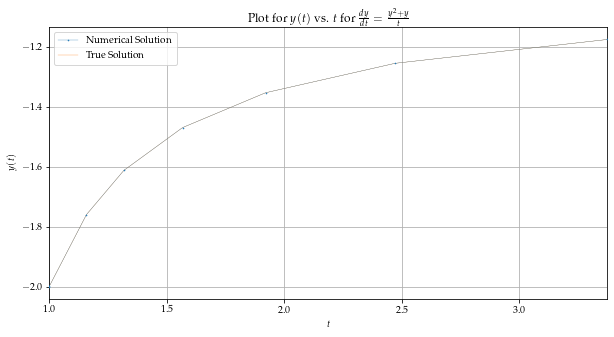

In [1954]:
# Solving the differential equation using RK4
diff_eq_q10.Runge_Kutta_4(delta=1e-4)
# Plotting the result
f10, ax10 = diff_eq_q10.plot(
    plot_index = 0,
    title = r'Plot for $y(t)$ vs. $t$ for $\frac{dy}{dt}=\frac{y^2+y}{t}$', 
    xlabel = r'$t$', 
    ylabel = r'$y(t)$',
    style = '-o',
    markersize = 0.6,
    linewidth = 0.3)

# Plotting the true solution
ax10.plot(diff_eq_q10.x, np.vectorize(y_true)(diff_eq_q10.x), linewidth = 0.3, label='True Solution')
ax10.legend()
f10.savefig('q10plot.pdf',bbox_inches='tight')

In [1955]:
diff_eq_q10.error(y_true, error_type="absolute", order=inf)

2.1044754801469168e-05

In [1956]:
diff_eq_q10.n

8

# Problem 11

In [1957]:
# Function definitions and initializations
def f(u,x):
    t = u/(1-u)
    return (1+t)**2/(x**2+t**2)

def u(t):
    return t/(1+t)

def t(u):
    return u/(1-u)
    
domain = [0, 1]
h = 1e-4
y0 = [1]
fn = [f]

In [1958]:
# Defining the differential equation with adaptive step size
diff_eq_q11 = diff_eq_solver(domain,h,y0,fn,stepsize="adaptive")

In [1959]:
# Calculating the precision required
t_test = 3.5e6
delta = 1/(1+t_test)**2
delta

8.163260641401416e-14

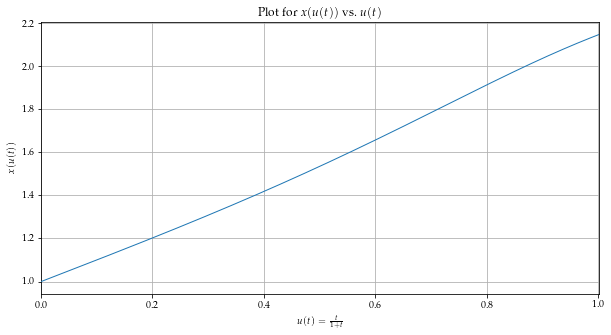

In [1960]:
# Solving the differential equation using RK4 with adaptive stepsize
diff_eq_q11.Runge_Kutta_4(delta=delta)
# Plotting the result
f11, ax11 = diff_eq_q11.plot(
    plot_index = 0,
    title = r'Plot for $x(u(t))$ vs. $u(t)$', 
    xlabel = r'$u(t)=\frac{t}{1+t}$', 
    ylabel = r'$x(u(t))$')

f11.savefig('q11plot.pdf',bbox_inches='tight')

In [1961]:
# Calculating the value of y for the test t
u_test = u(t_test)
diff_eq_q11.y[0,np.argmin(np.abs(diff_eq_q11.x-u_test))]

2.1443448613440648

# Problem 12

In [1962]:
# Function definitions and initializations
def f1(t,u1,u2,u3):
    return u1+2*u2-2*u3+np.exp(-t)

def f2(t,u1,u2,u3):
    return u2+u3-2*np.exp(-t)

def f3(t,u1,u2,u3):
    return u1+2*u2+np.exp(-t)
    
domain = [0, 1]
h = 0.0001
y0 = [3,-1,1]
fn = [f1,f2,f3]

In [1963]:
# Defining the differential equation
diff_eq_q12 = diff_eq_solver(domain,h,y0,fn)

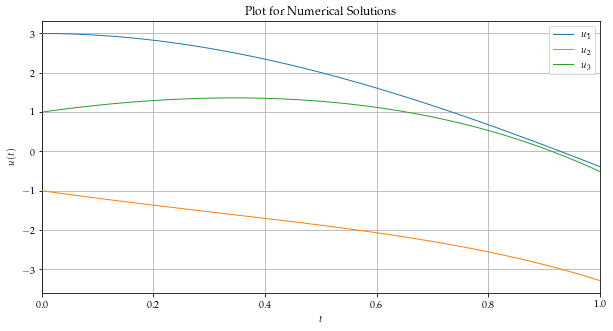

In [1964]:
# Solving the differential equation using RK4
diff_eq_q12.Runge_Kutta_4(delta=1e-4)
# Plotting the result
f12, ax12 = diff_eq_q12.plot(
    plot_label = ['$u_1$','$u_2$','$u_3$'],
    title = r'Plot for Numerical Solutions', 
    xlabel = r'$t$', 
    ylabel = r'$u(t)$')
ax12.legend()
f12.savefig('q12plot.pdf',bbox_inches='tight')

# Problem 14

In [1971]:
# Defining the functions and the initial conditions.
def dydt(t,y,v):
    return v

def dvdt(t,y,v):
    return (np.log(t)*t**3-2*y+2*t*v)/t**2

def true_y(t):
    return 7*t/4+((t**3)/2)*np.log(t)-(3/4)*(t**3)

fn = [dydt, dvdt]
y0 = [1, 0]
h= 0.001
domain = [1,2]

In [1972]:
# Defining the differential equation
diff_eq_q14 = diff_eq_solver(domain,h,y0,fn)

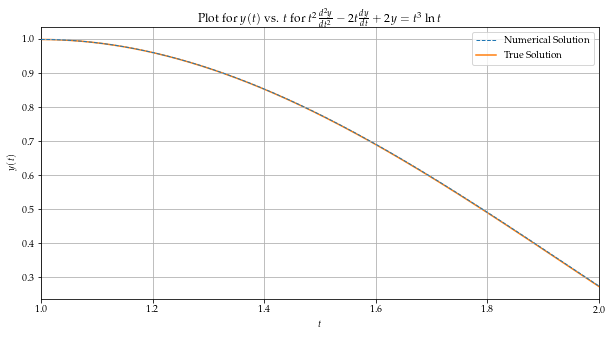

In [1973]:
# Solving the differential equation using RK4
diff_eq_q14.Euler_Method()
# Plotting the result
f14, ax14 = diff_eq_q14.plot(
    plot_index = 0,
    title = r'Plot for $y(t)$ vs. $t$ for $t^2\frac{d^2y}{dt^2}-2t\frac{dy}{dt}+2y=t^3\ln t$', 
    xlabel = r'$t$', 
    ylabel = r'$y(t)$',
    style = '--')

# Plotting the true solution
ax14.plot(diff_eq_q14.x, np.vectorize(true_y)(diff_eq_q14.x), label='True Solution',zorder=1)
ax14.legend()
f14.savefig('q14plot.pdf',bbox_inches='tight')